<a href="https://colab.research.google.com/github/pulkitjatt/market-segmentation/blob/main/market_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("mcdonalds.csv")

In [3]:
cols = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast',
        'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']
df[cols] = df[cols].applymap(lambda x: 1 if x == "Yes" else 0)

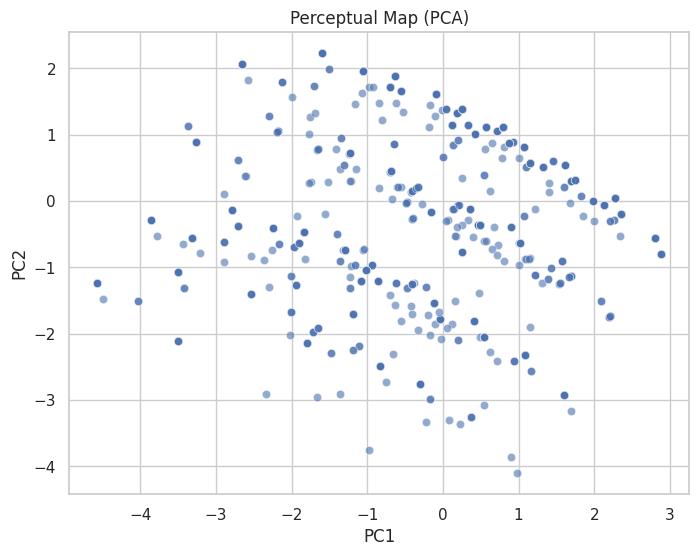

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cols])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df["PC1"], df["PC2"] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=df, alpha=0.6)
plt.title("Perceptual Map (PCA)")
plt.show()

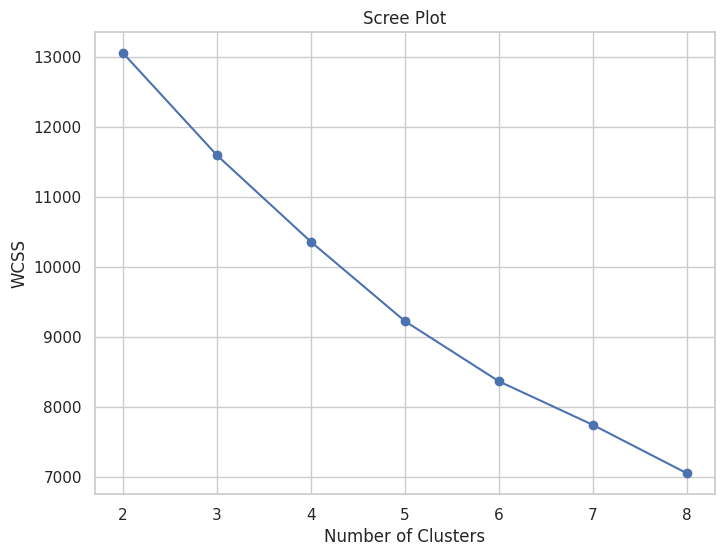

In [5]:
wcss = []
k_range = range(2, 9)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title("Scree Plot")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

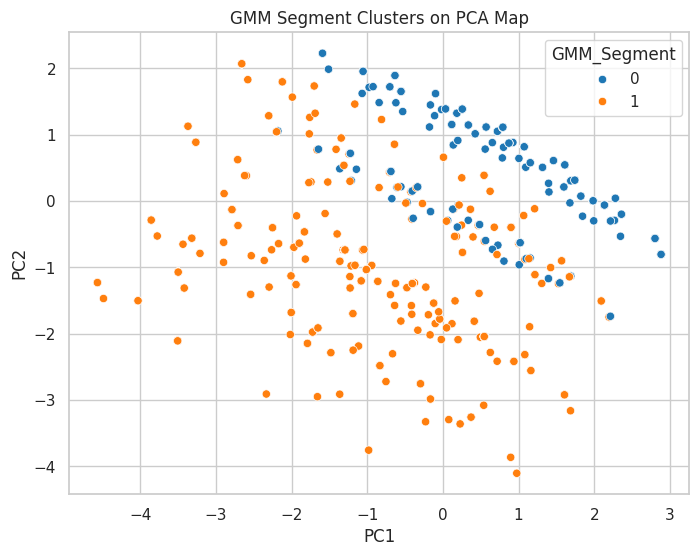

In [6]:
gmm = GaussianMixture(n_components=2, n_init=10, random_state=42)
df["GMM_Segment"] = gmm.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="GMM_Segment", data=df, palette="tab10")
plt.title("GMM Segment Clusters on PCA Map")
plt.show()

In [7]:
like_map = {
    "I love it!+5": 1, "+4": 2, "+3": 3, "+2": 4, "+1": 5,
    "0": 6, "-1": 7, "-2": 8, "-3": 9, "-4": 10, "I hate it!-5": 11
}
df["LikeCode"] = df["Like"].map(like_map)
df["Like_n"] = 6 - df["LikeCode"]

combined = np.column_stack((X_scaled, df["Like_n"]))
gmm_reg = GaussianMixture(n_components=2, n_init=10, random_state=42)
df["RegMix_Segment"] = gmm_reg.fit_predict(combined)

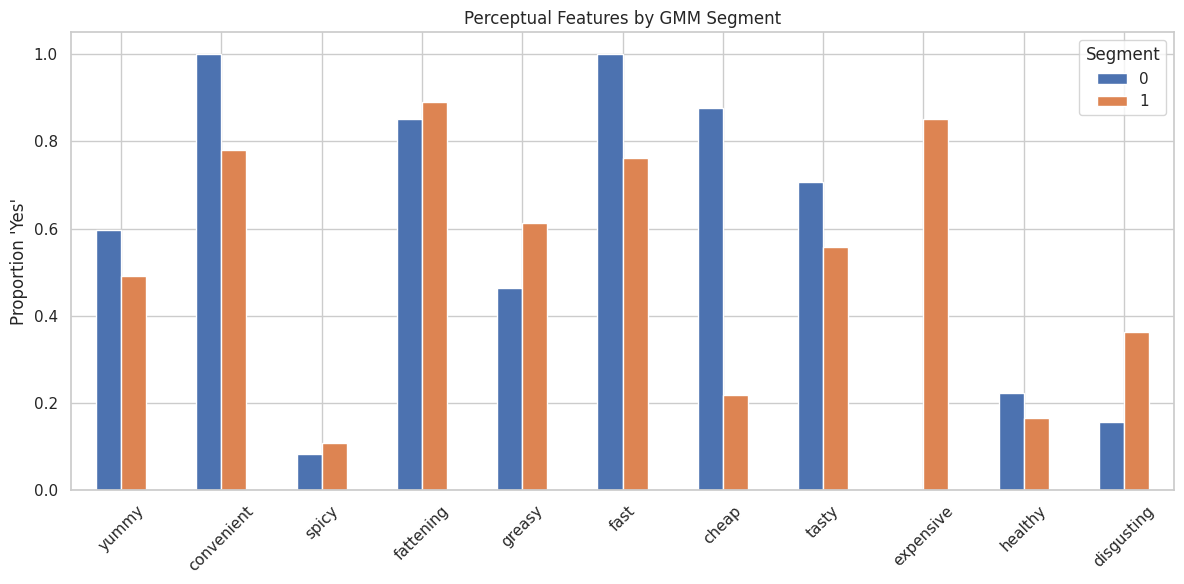

In [8]:
seg_profile = df.groupby("GMM_Segment")[cols].mean().T

seg_profile.plot(kind="bar", figsize=(12, 6))
plt.title("Perceptual Features by GMM Segment")
plt.ylabel("Proportion 'Yes'")
plt.xticks(rotation=45)
plt.legend(title="Segment")
plt.tight_layout()
plt.show()

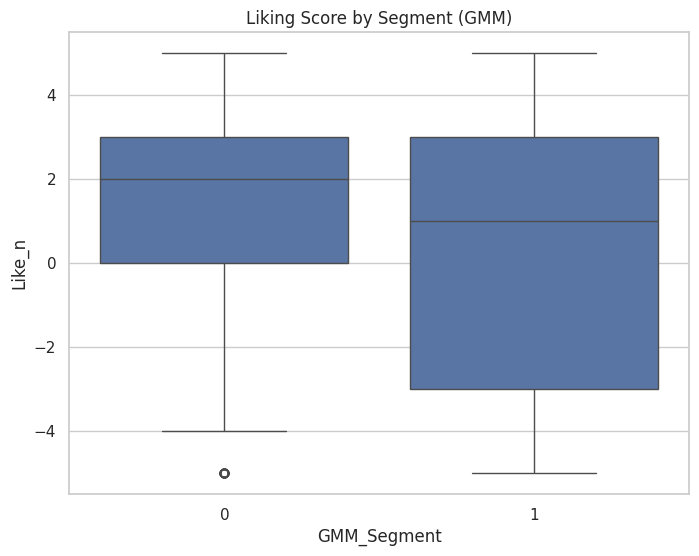

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="GMM_Segment", y="Like_n", data=df)
plt.title("Liking Score by Segment (GMM)")
plt.show()

In [11]:
if "Freq" in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="Freq", y="Like_n", hue="GMM_Segment", data=df)
    plt.title("Frequency vs Liking by Segment")
    plt.show()

In [13]:
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,...,Like,Age,VisitFrequency,Gender,PC1,PC2,GMM_Segment,LikeCode,Like_n,RegMix_Segment
0,0,1,0,1,0,1,1,0,1,0,...,-3,61,Every three months,Female,-0.704334,0.437016,1,9,-3,0
1,1,1,0,1,1,1,1,1,1,0,...,+2,51,Every three months,Female,0.467820,-0.364277,1,4,2,0
2,0,1,1,1,1,1,0,1,1,1,...,+1,62,Every three months,Female,-0.191986,-1.712949,1,5,1,0
3,1,1,0,1,1,1,1,1,0,0,...,+4,69,Once a week,Female,0.116991,1.155122,0,2,4,1
4,0,1,0,1,1,1,1,0,0,1,...,+2,49,Once a month,Male,0.034724,1.390267,0,4,2,0
